<a href="https://colab.research.google.com/github/hritik880/GANS-/blob/master/fashion_mnist_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image)
        plt.axis("off")

In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


In [ ]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32)/ 255.0
x_test = x_test.astype(np.float32)/ 255.0

4423680/4422102 [==============================] - 0s 0us/step


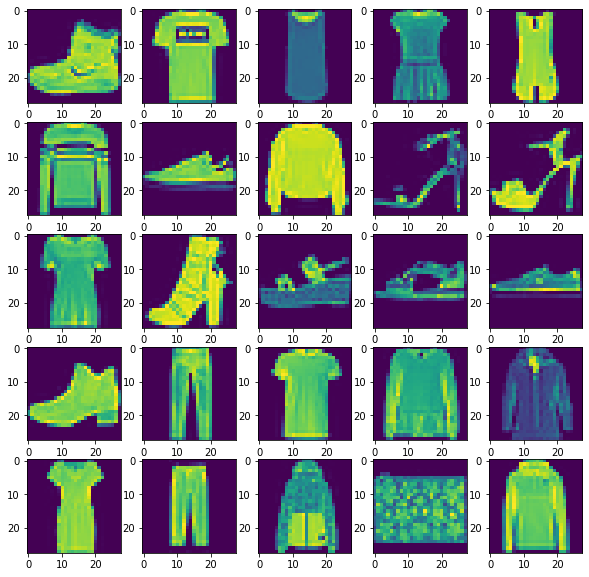

In [ ]:
plt.figure(figsize= (10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i])
    

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder = True).prefetch(1)

In [ ]:
num_features = 100
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*256 ,input_shape = [num_features],activation = 'relu'),
    keras.layers.Reshape([7,7,256]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(128,(5,5), (2,2),padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64,(5,5), (2,2),padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1,(5,5), (1,1),padding = 'same', activation = 'tanh')
])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        2

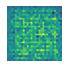

In [ ]:
noise = tf.random.normal(shape = [1,num_features])
generated_image = generator(noise,training = False)
show(generated_image, 1 )

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5,5) ,  (2,2) , padding ='same', input_shape =[28,28,1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128,(5,5), (2,2),padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Conv2D(256,(5,5), (2,2),padding = 'same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)        

In [ ]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5001177]], shape=(1, 1), dtype=float32)


In [ ]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable  = False
gan= keras.models.Sequential([generator,discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')

In [ ]:
seed = tf.random.normal(shape = [batch_size , 100])

In [ ]:
def train_dcgan(gan , dataset ,batch_size , num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("epoch {}/{}".format(epoch + 1 ,epochs))
        for X_batch in dataset:
            #creating random noise of shape (batch_size ,num_of_features)
            noise = tf.random.normal(shape = [batch_size,num_features])
            #initilally generating image from untrained generator to train discriminator
            generated_images = generator(noise)
            #concatinating images
            X_fake_and_real = tf.concat([generated_images,X_batch],axis =0)
            # creating a list y1 which contains true_labels for images
            y1 = tf.constant([[0.]]*batch_size + [[0.9]]*batch_size) 
            #training the discriminaator 
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real,y1)
            #training generator now
            y2 = tf.constant([[1.0]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise,y2)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch+1 ,seed)
    display.clear_output(wait = True)
    generate_and_save_images(generator, epochs , seed)

In [ ]:

output_dir = r'/content/drive/My Drive/fashion_mnist'
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
        
    plt.savefig(output_dir + '/image_at_epoch_{:04d}.png'.format(epoch + 50))
    plt.show()

In [ ]:
x_train_dcgan =  x_train.reshape(-1,28,28,1)* 2. -1

In [ ]:
batch_size = 32
dataset =  tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder = True).prefetch(1)

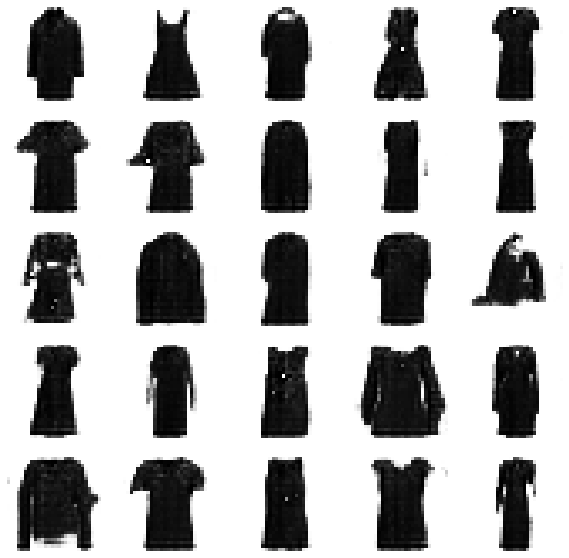

CPU times: user 42min 36s, sys: 3min 48s, total: 46min 24s
Wall time: 1h 31min 29s


In [ ]:
%%time
train_dcgan(gan,dataset, batch_size, num_features,epochs =50)


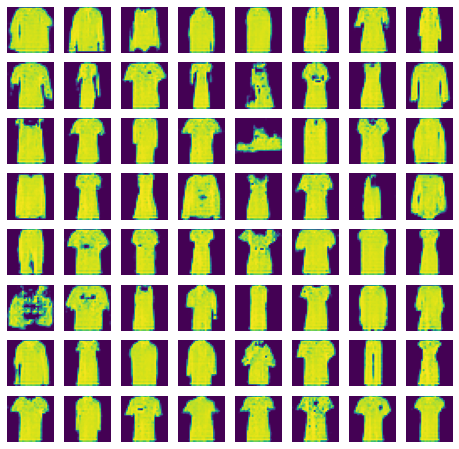

In [ ]:
noise = tf.random.normal(shape = [64,num_features])
generated_images = generator(noise)
show(generated_images,8)